In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
import seaborn as sns

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams, conv #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [450]:
qb = 17 # qubit to operate on

# Conversion factors from standard SI units
us = 1e6
ns = 1e9
GHz = 1e-9

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 17 has a 
  - T1 time of 55.05871343301275 microseconds
  - T2 time of 57.499571716205935 microseconds
  - U2 gate error of 0.00033960099361554825
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.724685917937708 GHz


In [529]:
shots = 1024 # determines clarity of results

period = 3000 # Rabi oscillation period
cycles = [5, 20, 40, 80, 160] # number of rabi cycles to perform for each oscillation
cycles_to_plot = 3 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const_arr = [54.07447683508908, 23.66156363955276, 60.71437458094607, 39.3158030358485, 99.20715774307718, 49.95313684255335, 58.41743781494493, 25.581627006241156, 59.29925139248408, 66.48049584501037,  55.96049466992817, 61.0468753438098,  69.53956380480695, 53.04738616311787, 35.92255650292224, 70.92519866266184, 76.16056132506117, 66.61375917115514, 80.8160184821598, 39.766803375498874]
predict_power_arr =  [-0.9924372112785861, -0.9940037912357684, -0.9478600149564859, -0.9990003473358622, -0.9545547178832068, -0.9741980721203277, -0.9507668252877607, -0.988440471817147, -0.9705356561002346, -0.9759707562681753, -0.9863270037625501, -0.9919133368276755, -0.9688283405688723, -0.9755092917894524, -0.9784188437551748, -0.9561175027847064, -0.9607519043146192, -0.9620204924453801, -0.9765823562601296, -0.9826959748384742]
predict_const = predict_const_arr[qb]
predict_power = predict_power_arr[qb]

sig_predict_const_arr = [11.48089749887833, 5.35893609525708, 11.45245806804462, 8.422591490016428, 8.422591490016428, 10.668276009484188, 11.650031111752481, 5.687450116117995, 11.519876740103824, 13.072317572938855, 10.156982416076294, 11.929204320355337, 13.41656375569742, 11.09074144750751, 7.601093075606327, 15.113382279092622, 16.434457262102157, 13.78818074531042, 15.740548839704724, 8.565551825229692]
sig_predict_power_arr = [-0.9672752940591574, -0.9654741107610489, -0.9847146457687506, -0.9748121973084468, -0.9748121973084468, -0.9604334841997333, -0.9691865136543687, -0.9648929117844334, -0.9862872564599189, -0.9827775368102274, -1.026503852980569, -0.9990248777026389, -0.9910375292741338, -0.9659428057129544, -0.9666488482050365, -0.9420720154939807, -0.9389201013042705, -0.9609761215025634, -0.9949494583639722, -0.9671575177512337]
sig_predict_const = sig_predict_const_arr[qb]
sig_predict_power = sig_predict_power_arr[qb]

In [530]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = period // 64 # density of datapoints in a cycle capture
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        64)
    
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = get_closest_multiple_of_16(drive_times[i] - (6 * drive_sigma))

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
                    
        # add end cap
        this_schedule += Play(end_cap, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

In [531]:
len(experiments)

702

In [532]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [518]:
job = backend.retrieve_job('5f1b5a1ebb1ebb0013c62d89')

In [519]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [520]:
qb_rabi_data = []
all_params = []
all_fits = []
all_convs = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p, c = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 5])
    all_params.append(p)
    all_convs.append(c)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    
    single_period_data = np.array(single_period_data)
    # residual sum of squares
    ss_res = np.sum((single_period_data - np.array(y_fit)) ** 2)
    # total sum of squares
    ss_tot = np.sum((single_period_data - np.mean(single_period_data)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    
    all_fits.append(y_fit)

0.9968201476159557
0.9937106254995629
0.9893227591015933
0.9726005943485437
0.827800957133794


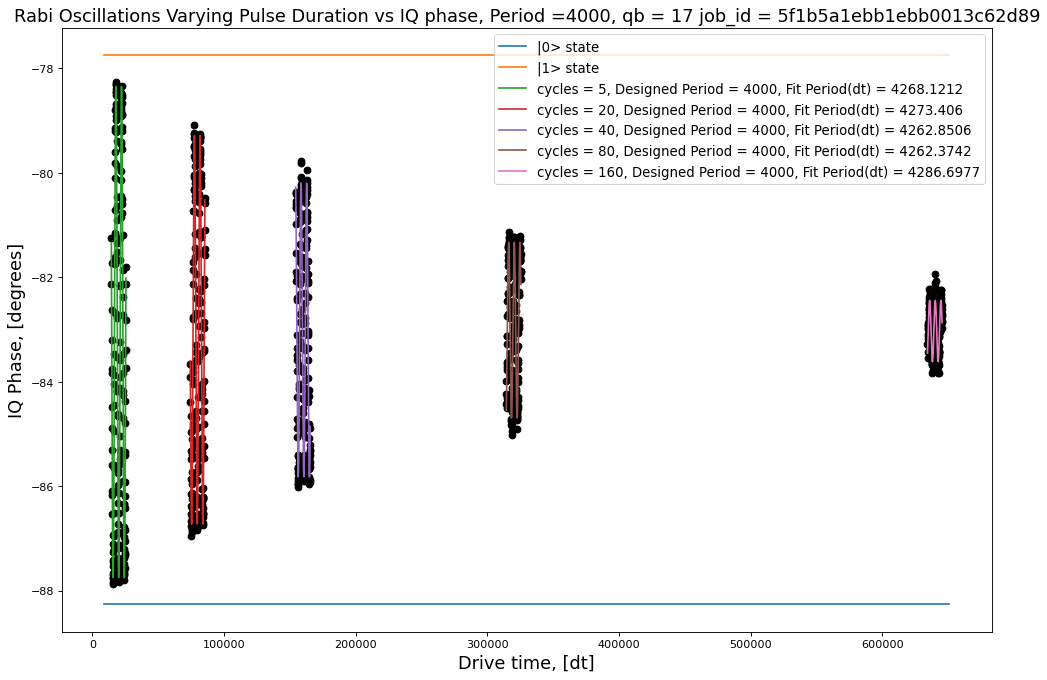

In [521]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

start_plot_time = (period*cycles[0])-(len(data_times[0]) * 64)
end_plot_time = (period*cycles[-1])+(len(data_times[-1]) * 64)
plt.plot([start_plot_time, end_plot_time],2*[state0],label="|0> state")
plt.plot([start_plot_time, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb) + " job_id = " + str(job.job_id()), fontsize=16)
# plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase", fontsize=16)
plt.show()

In [522]:
sigma = []
for i in all_convs:
    print(i)
    perr = np.sqrt(np.diag(i))
    print(perr)
    sigma.append(perr[0])
    print()

[[ 4.16385572e-04  4.57907996e-05 -3.96376880e-03  2.66202237e-05]
 [ 4.57907996e-05  2.02387724e-04  5.91969876e-03 -4.14946160e-05]
 [-3.96376880e-03  5.91969876e-03  1.28694556e+01 -8.85622548e-02]
 [ 2.66202237e-05 -4.14946160e-05 -8.85622548e-02  6.26359425e-04]]
[0.02040553 0.0142263  3.58740234 0.02502717]

[[ 5.16954039e-04 -5.35088070e-05  4.04774481e-03 -1.17048551e-04]
 [-5.35088070e-05  2.55878633e-04  8.76496478e-03 -2.34682935e-04]
 [ 4.04774481e-03  8.76496478e-03  2.73217513e+01 -7.53496401e-01]
 [-1.17048551e-04 -2.34682935e-04 -7.53496401e-01  2.08153391e-02]]
[0.02273662 0.01599621 5.22702126 0.14427522]

[[ 5.04560872e-04  3.34276368e-05  6.60324349e-03 -3.73556582e-04]
 [ 3.34276368e-05  2.62400738e-04  8.25867131e-03 -4.75168857e-04]
 [ 6.60324349e-03  8.25867131e-03  5.59467865e+01 -3.09116004e+00]
 [-3.73556582e-04 -4.75168857e-04 -3.09116004e+00  1.70858923e-01]]
[0.02246243 0.01619879 7.47975845 0.41335085]

[[ 4.69327784e-04  3.79408150e-05 -4.32805634e-03  4

In [523]:
for i in range(len(cycles)):
    print(f'{abs(np.array(all_params)[:,0][i])}')
print()
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')
print()
print(sigma)

4.703554147668113
3.7210981240821455
2.8138074007038156
1.6802989507231403
0.5866478127702712

9.619390620076288
7.870381718331032
6.244388186632818
3.8789135853197365
1.9073496781028467

[0.02040552798721825, 0.022736623289610437, 0.022462432454338335, 0.02166397432614623, 0.020547695765065096]


0.9994109924841142


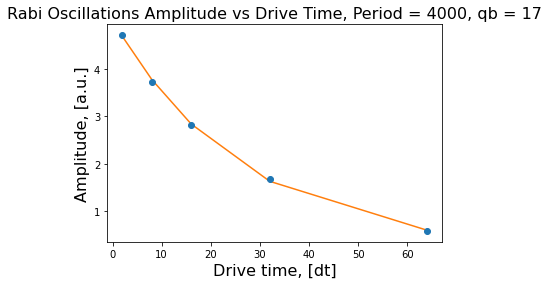

In [524]:
xvals = [(period*i)/10000 for i in cycles]
amps = abs(np.array(all_params)[:,0])
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, conv = curve_fit(func, xvals, amps, [4, 0.1, 1], sigma)
y_fit = [func(x, p[0], p[1], p[2]) for x in xvals]

amps = np.array(amps)
# residual sum of squares
ss_res = np.sum((amps - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((amps - np.mean(amps)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(xvals, amps, yerr=sigma, fmt='o')
plt.plot(xvals, y_fit)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Rabi Oscillations Amplitude vs Drive Time, Period = " + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [525]:
print(p)
print(f'{p[1]}')
print(f'{drive_amp}')
print(conv)

[4.86831471 0.0373542  0.15748166]
0.03735419672215851
0.014167423937207418
[[ 9.62218828e-03 -1.27618728e-04 -8.89445008e-03]
 [-1.27618728e-04  4.93354936e-06  2.16994746e-04]
 [-8.89445008e-03  2.16994746e-04  1.18506880e-02]]


[0.059857634, 0.039271401, 0.029120928, 0.023092412, 0.019105661, 0.016276922, 0.014167424]
[0.07995037651975703, 0.04631965051975703, 0.026240105519757036, 0.019802253519757035, 0.016604407519757038, 0.027130899519757036, 0.019191767519757034]
[0.02466231943674398, 0.003887178758431364, 0.0059146111621982385, 0.0028137567911957137, 0.0002509964298550878, 0.0028030832167454463, 0.002221159462983241]
0.28356219751619394


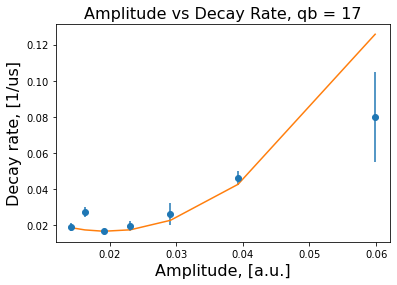

[ 6.73700204e+01 -2.64598331e+00  4.26843513e-02]


In [528]:
qb = 17

more_conv = [
[[ 0.17635706, -0.00929068, -0.19083502],
 [-0.00929068,  0.00060823,  0.01100242],
 [-0.19083502,  0.01100242,  0.21652995]],
[[ 1.38934524e-02, -4.13961506e-04, -1.49903884e-02],
 [-4.13961506e-04,  1.51101587e-05,  4.84727985e-04],
 [-1.49903884e-02,  4.84727985e-04,  1.68678845e-02]],
[[ 9.97872245e-02, -1.72272479e-03, -1.08683281e-01],
 [-1.72272479e-03,  3.49826252e-05,  1.99923502e-03],
 [-1.08683281e-01,  1.99923502e-03,  1.22195047e-01]],
[[ 2.83257452e-02, -4.29853703e-04, -3.06899748e-02],
 [-4.29853703e-04,  7.91722728e-06,  5.04211635e-04],
 [-3.06899748e-02,  5.04211635e-04,  3.46436763e-02]],
[[ 3.28432243e-04, -3.92519441e-06, -3.58817713e-04],
 [-3.92519441e-06,  6.29992078e-08,  4.91202684e-06],
 [-3.58817713e-04,  4.91202684e-06,  4.22734276e-04]],
[[ 1.13796227e-02, -1.58962294e-04, -1.02459981e-02],
 [-1.58962294e-04,  7.85727552e-06,  2.91237215e-04],
 [-1.02459981e-02,  2.91237215e-04,  1.38150165e-02]],
[[ 9.62218828e-03, -1.27618728e-04, -8.89445008e-03],
 [-1.27618728e-04,  4.93354936e-06,  2.16994746e-04],
 [-8.89445008e-03,  2.16994746e-04,  1.18506880e-02]]
]

gammas_tilde = [0.098112806, 0.06448208, 0.044402535, 0.037964683, 0.034766837, 0.045293329, 0.037354197]
amplitudes = [0.059857634, 0.039271401, 0.029120928, 0.023092412, 0.019105661, 0.016276922, 0.014167424]


more_sigma = [np.sqrt(np.diag(i))[1] for i in more_conv]
gammas = [g - 1/(props.t1(qb) * us) for g in gammas_tilde]
print(amplitudes)
print(gammas)
print(more_sigma)


def func(x, a, b, c):
    return  a * x**2 + b*x + c

p, pcov = curve_fit(func, amplitudes, gammas, [5, 0, 0], more_sigma, maxfev=5000)
y_fit = [func(x, p[0], p[1], p[2]) for x in amplitudes]

gammas = np.array(gammas)
ss_res = np.sum((gammas - np.array(y_fit)) ** 2)
ss_tot = np.sum((gammas - np.mean(gammas)) ** 2)
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(amplitudes, gammas, yerr=more_sigma, fmt='o')
plt.plot(amplitudes, y_fit)
plt.ylabel('Decay rate, [1/us]', fontsize=16)
plt.xlabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Amplitude vs Decay Rate, qb = " + str(qb), fontsize=16)
plt.show()

print(p)

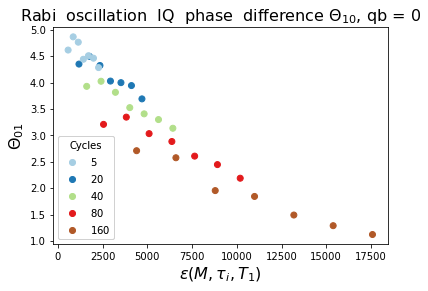

In [826]:
errors = []
cycles = np.array([5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160])
periods = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
inv_T1 = 1 / (props.t1(qb) * us)

# 0
amps = [4.617710739, 4.351782188, 3.929665083, 3.209085447, 2.709938099, 4.867971959, 4.498334917, 4.026202528, 3.346237366, 2.576509753, 4.766859053, 4.32508765, 3.816748538, 3.03355349, 1.953926147, 4.443016216, 4.029763913, 3.526323838, 2.884357198, 1.84297663, 4.50958548, 3.999831676, 3.408507583, 2.607163711, 1.490607971, 4.463362893, 3.944515979, 3.300074297, 2.446771991, 1.289007061, 4.28538436, 3.692278193, 3.135415908, 2.188505079, 1.12132314] 
drive_amps = [0.052885571, 0.035148278, 0.026303481, 0.021007033, 0.017481556, 0.014966599, 0.013082455]

# 1
# drive_amps = [0.023133165, 0.015384435, 0.01151832, 0.009202260, 0.007660121, 0.006559715, 0.005735129]
# amps = [5.217778043, 4.900298225, 4.326107335, 3.305675878, 2.554938727, 5.160890116, 4.791931535, 4.232594026, 3.422909473, 2.330834417, 4.830029438, 4.423696332, 3.904144607, 3.130780893, 1.937175946, 4.764755353, 4.293668577, 3.743870731, 2.776513202, 1.492134534, 4.506360486, 3.952414952, 3.389685403, 2.308164952, 1.130503695, 4.378633976, 3.621083366, 2.875296868, 1.880704351, 0.690863676, 4.411964711, 3.69448767, 2.869647208, 1.738978546, 0.626818586]

# 2
# amps = [5.169386522, 4.80509715, 4.270998247, 3.301432287, 2.614330931, 5.280759799, 4.806251265, 4.137688096, 3.228113698, 2.136992405, 5.034989787, 4.450650074, 3.707702977, 2.810048099, 1.519823141, 4.989927734, 4.313067179, 3.562169265, 2.671217305, 1.436595475, 5.181363676, 4.291003189, 3.390677881, 2.20254634, 0.769096765, 5.154230587, 4.175068246, 3.229970662, 1.868669769, 0.560512069, 5.043815259, 3.947775996, 2.938557323, 1.497401102, 0.374014087]
# drive_amps = [0.052043045, 0.033930088, 0.025048032, 0.019793963, 0.016330365, 0.013879266, 0.01205548]

# 3
# amps = [6.548200286, 6.097478037, 5.329903384, 4.136142459, 3.118622692, 6.493532934, 5.933431128, 5.250198956, 4.240421856, 2.926080452, 6.419550687, 5.720217525, 4.935832663, 3.798393393, 2.163036939, 6.316390062, 5.48439175, 4.59474914, 3.411623117, 1.795112361, 6.108172728, 5.09060978, 4.042035449, 2.647884907, 1.100107249, 6.214888138, 5.214541395, 4.127022197, 2.600809111, 1.033097265, 6.101224926, 4.97671265, 3.803022783, 2.258496391, 0.797468539]
# drive_amps = [0.039188695, 0.026115199, 0.019580762, 0.015661112, 0.013048546, 0.011182743, 0.009783593]

# 5
# amps = [7.112178429, 6.638073573, 5.983393175, 4.747236664, 3.571318274, 7.029248243, 6.541458087, 5.760820502, 4.663010912, 3.245267045, 6.850863993, 6.147242447, 5.309817569, 4.142614001, 2.556364985, 6.673694467, 5.887723672, 4.944123073, 3.714292451, 2.078414806, 6.634020366, 5.748504666, 4.735261204, 3.335250684, 1.649039802, 6.445016352, 5.443587417, 4.404954938, 2.831882654, 1.258419783, 6.693267364, 5.451135685, 4.232957959, 2.639611335, 1.05313914]
# drive_amps = [0.046141723, 0.030432576, 0.022651186, 0.018014169, 0.014939493, 0.012753106, 0.011119572]


# 6 
# amps = [7.794385564, 7.314756449, 6.534663126, 5.155190578, 3.677232162, 7.710920819, 7.10595888, 6.239960945, 4.897293221, 3.177698529, 7.661532422, 6.761881944, 5.694974098, 4.223654648, 2.166016201, 8.195490206, 7.062383506, 5.759999416, 4.031762282, 1.894592844, 7.420854725, 6.187528312, 4.989780937, 3.340711713, 1.413703253, 7.439420734, 6.121809265, 4.746345989, 2.843517823, 1.014688675, 7.045995691, 5.689663158, 4.295489596, 2.38424209, 0.804127729]
# drive_amps = [0.050427899, 0.0329201, 0.024324995, 0.019236431, 0.015879727, 0.013502978, 0.011733691]



for i in range(len(drive_amps)):
    for j in range(5):
        errors.append(cycles[j] * periods[i] * (inv_T1 + func(drive_amps[j], p[0], p[1], p[2])))

fig, ax = plt.subplots()
scatter = ax.scatter(errors, amps, c=cycles, cmap="Paired")
# plt.plot(errors, y_fit, color='black')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cycles")
ax.add_artist(legend1)
plt.ylabel('$\Theta_{01}$', fontsize=16)
plt.xlabel('$\epsilon(M, \\tau_i, T_1)$', fontsize=16)
plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$, qb = " + str(qb), fontsize=16)
plt.show()

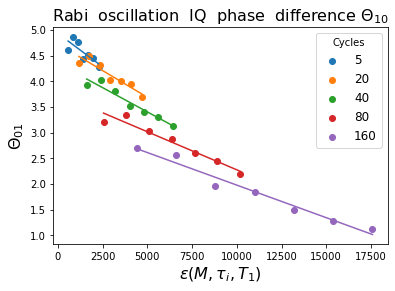

In [829]:
p_s = []
y_fits = []

def lin_func(x, m, b):
    return m * x + b

for i in range(5):
    indices = np.where(np.array(cycles) == cycles[i])[0]
    e = [errors[x] for x in indices]
    a = [amps[x] for x in indices]
    plt.scatter(e, a, label = str(cycles[i]))
    lin_p, _ = curve_fit(lin_func, e, a)
    p_s.append(lin_p)
    y_fits.append([lin_func(x, lin_p[0], lin_p[1]) for x in e])
    plt.plot(e, y_fits[i])
plt.legend(loc='upper right', title="Cycles", fontsize=12)
plt.ylabel('$\Theta_{01}$', fontsize=16)
plt.xlabel('$\epsilon(M, \\tau_i, T_1)$', fontsize=16)
# plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$, qb = " + str(qb), fontsize=16)
plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$", fontsize=16)

plt.show()

In [286]:
p_s

[array([-2.10627696e-04,  4.93331846e+00]),
 array([-1.97556806e-04,  4.72940740e+00]),
 array([-1.95907696e-04,  4.34957056e+00]),
 array([-1.57254570e-04,  3.76064304e+00]),
 array([-1.32083044e-04,  3.24849991e+00])]